In [3]:
#####################################
# Single Particle Tracking Analysis #
#####################################

# Install any Packages this way if you don't have them:
# %pip install seaborn

# Libraries Needed for data manipulation#
import numpy as np
import pandas as pd
# Library needed to handle csv converted dataframes
import ast
# Library needed to change working directories within the code 
import os
# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="colorblind")
sns.set_context("talk")
# Library for statistics and linear regression
from scipy import stats
# Library for latex 
from IPython.display import Latex

### Diffusion Coefficient Calculation for SPT ##

#############
# Variables #
#############

# fileName = the name of your file as a string without the .csv ending
# sample_id = sample identifier 
# min_lifetime = minimum lifetime of a track in frames
# time_per_frame = time per frame in seconds
# min_disp = minimum displacement in microns; tracks with a total displacement over this value will not be filtered out

############
# Outputs #
###########

# "[sample_id]_Filtered" csv: Tracks filtered by minimum lifetime
# Dataframe containing the same tracks as stored in the csv, with additional information:
# Lifetime in frames and seconds, time averaged MSD, D calculated from TA-MSD, and a list of MSDs calculated with increasing time lags
# (beginning at time lag = time per frame in seconds)
#    ---> The Dataframe is returned by the function; ie, when you run this function, you can set output = focitracker()
#         and this dataframe is stored in the output variable
# "[sample_id]_diffusion_coef" csv: Same information as in the Dataframe

def focitracker(fileName, sample_id, min_lifetime, time_per_frame, min_disp = None):
    fociData = pd.read_csv(fileName+'.csv')
    
    foci_to_keep = []
    for i in range(len(fociData)): #i is the index for all rows in the dataset
        if fociData["TrackObjects_Lifetime"][i] == min_lifetime and pd.notna(fociData["TrackObjects_Label"][i])==True:
            foci_to_keep.append(fociData["TrackObjects_Label"][i])
    fociData_filtered = fociData[fociData["TrackObjects_Label"].isin(foci_to_keep)]
    fociData_filtered.to_csv(fileName + '_Filtered' + '.csv')
    
    data_by_foci = fociData_filtered.groupby("TrackObjects_Label")
    Ds = np.zeros((len(foci_to_keep), 7), dtype=object ) # sets up a blank array with 7 columns; #of rows = #of foci
    i= 0
   
    for group in foci_to_keep:
        cur_foci = data_by_foci.get_group(group)
        Ds[i,0] = group # foci identifier
    
        lifetime_f = len(cur_foci["TrackObjects_Lifetime"])
        Ds[i,1] = lifetime_f # lifetime of the track in frames
    
        lifetime_s = len(cur_foci["TrackObjects_Lifetime"])* time_per_frame
        Ds[i,2] = lifetime_s # lifetime of the track in seconds
        
        x_positions = cur_foci["Location_Center_X"].tolist()
        y_positions = cur_foci["Location_Center_Y"].tolist()
        num_positions = len(x_positions)
        MSDs = np.zeros(num_positions)
        for time_lag in range(1,num_positions): #the time lag progressively increases
            displacements_squared = []
            for j in range(num_positions - time_lag):#at the smallest time lag, MSD is calculated betweeen each pos. At the largest time lag, MSD is calculated between the final and the initial pos.
                displacement_x = (x_positions[j+time_lag] - x_positions[j])
                displacement_y = (y_positions[j+time_lag] - y_positions[j])
                displacements_squared.append(displacement_x**2 + displacement_y**2)
                if time_lag == num_positions-1:
                    Ds[i,3] = np.sqrt(displacement_x**2 + displacement_y**2) #total displacement
            MSDs[time_lag] = np.mean(displacements_squared) #The MSD is time averaged differently based on the time lag.
            
        Ds[i,4] = MSDs[min_lifetime-1] #Take the time averaged MSD for the particular time lag that corresponds to the min lifetime. The index is one less than min_lifetime
     #Diffusion coefficient (um^2/s)
        Ds[i,5] = MSDs[min_lifetime-1]/(4*(min_lifetime*time_per_frame)) #Comes from D = MSD/2*n*t where n is the number of dims (2 for x,y), and t is min lifetime of the track
        Ds[i,6] = MSDs.tolist()

        i += 1

    Ds_dataframe = pd.DataFrame(Ds, columns = ['foci_n', 
                                               'lifetime_f', 
                                               'lifetime_s',
                                               'total_disp',
                                               'TA-MSD',
                                               'D (from TA-MSD)',
                                               'msd_per_time_unit'])
    if min_disp != None:
        Ds_dataframe = Ds_dataframe[Ds_dataframe['total_disp'] >= min_disp].reset_index(drop=True)
    Ds_dataframe['sample_id'] = sample_id
    Ds_dataframe.to_csv(fileName + "_diffusion_coef.csv")
    
    return Ds_dataframe


In [4]:
### Conversion of TrackMate Tracks to equivalent formatting from CellProfiler foci files ###
# Originally, CellProfiler was used to track foci, and the code was written. Upon switching to TrackMate, we wrote this function
# rather than re-writing the rest of the code.

#############
# Variables #
#############

#directoryName: name 
def TrackMateConverter(directoryName):
    original_dir = os.getcwd()
    dir_path, fileName = os.path.split(directoryName)
    os.chdir(dir_path)
    fociData = pd.read_csv(fileName)
    fociData = fociData[3:]
    fociData = fociData.reset_index(drop=True)
    Ds = pd.DataFrame(columns=['TrackObjects_Label', 'ImageNumber', 'TrackObjects_Lifetime', 'Location_Center_X', 'Location_Center_Y'])
    data_by_foci = fociData.groupby("TRACK_ID")
    for track_id, cur_foci in data_by_foci:
        cur_foci['FRAME'] = cur_foci['FRAME'].convert_dtypes()
        cur_foci["FRAME"] = pd.to_numeric(cur_foci["FRAME"])
        cur_foci = cur_foci.sort_values(by='FRAME')
        cur_foci = cur_foci.reset_index(drop=True)
        cur_foci['TrackObjects_Lifetime'] = np.arange(1, len(cur_foci) + 1)
        new_entries = pd.DataFrame({
        'TrackObjects_Label': track_id,
        'ImageNumber': cur_foci['FRAME'],  
        'TrackObjects_Lifetime': cur_foci['TrackObjects_Lifetime'],
        'Location_Center_X': cur_foci["POSITION_X"], 
        'Location_Center_Y': cur_foci["POSITION_Y"]  
        }) #each dataframe contains all rows pertaining to the current foci
        Ds = pd.concat([Ds, new_entries], ignore_index=True)
    os.chdir(original_dir)
    csv = Ds.to_csv("CellProfilerFormat" + fileName, index=False)
    return "CellProfilerFormat" + fileName
    

In [14]:
from scipy.stats import linregress

### Graphing of Diffusion Coefficients and MSD Curves##

#############
# Variables #
#############

# dataset = the name of your Diffusion coefficient dataframe (output of focitracker function above)
# sample_id = sample identifier (what would you like to call it?) 
# min_lifetime = minimum lifetime of a track in frames (lowest lifetime possible = 1 frame)
# time_per_frame = time per frame in seconds (your exposure time/ collection rate on the microscope)
# r2_cutoff = the R^2 value of the linear fit of each MSD curve above or equal to which your MSD curve will be kept (default value = 0.7)
# rerun = Make this value "True" if you have converted the dataset (focitracker output) to a csv and then back to a dataframe

###########
# Outputs #
###########

# MSD vs Time plot and LOG-LOG plot, unfiltered by R^2 fit to linear portion on log-log plot
# MSD vs Time plot and LOG-LOG plot, filtered by R^2 fit to linear portion on log-log plot
# Distribution of D (um2/s), calculated from slope of the linear portion of the log-log MSD curve (only from MSDs filtered by R^2)
# Bestfit csv file: Contains information for all tracks that have been filtered by R^2 and lifetime (MSDs, Ds, fit information, and more)

def graphs(dataset, sample_id, min_lifetime, time_per_frame, r2_cutoff=0.7, rerun=False):
    
    #Plot the MSD curves for each track, in a subplot: Left is normal scale, right is log-log
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].set_title('Mean Squared Displacement over time of '+ sample_id+', unfiltered')
    for i in range(dataset.shape[0]):
        if rerun:
            string_representation = dataset['msd_per_time_unit'][i]
            list_of_values = ast.literal_eval(string_representation)
        else:
            list_of_values = dataset['msd_per_time_unit'][i]
        axs[0].plot(np.arange(time_per_frame,dataset['lifetime_s'][i] - 1e-9, time_per_frame), list_of_values[1:])
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("MSD ($\mu$m$^2$)")
    
    for i in range(dataset.shape[0]):
        lagtimes = np.arange(time_per_frame,dataset['lifetime_s'][i]+time_per_frame, time_per_frame)
        if rerun:
            string_representation = dataset['msd_per_time_unit'][i]
            list_of_values = ast.literal_eval(string_representation)
        else:
            list_of_values = dataset['msd_per_time_unit'][i]
        axs[1].loglog(np.arange(time_per_frame,dataset['lifetime_s'][i] - 1e-9, time_per_frame), list_of_values[1:])
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("MSD ($\mu$m$^2$)")
    axs[1].set_title('Log-Log Plot of MSD')
    
    plt.tight_layout()
    plt.savefig('MSDs_unfiltered'+sample_id+'.svg')
    plt.show()
    
    #Fit the first min_lifetime frames to a linear equation (D = slope) and show the MSD curves in a log-log axes scaled plot
    #Recalculates the Diffusion Coefficient of each track from the linear range of the MSD vs time lag, t (MSD = 4Dt)
    #The linear region of a curve is more clearly seen on the log-log plot.
    #If R2 is above r2_cutoff, we assume that the beginning of the track (including the first [min_lifetime] frames) include the best linear region
    #Otherwise, the MSD curve is assumed to drop off in quality before those first [min_lifetime] frames.
    Ds_recalculated = np.zeros((dataset.shape[0], 7), dtype=object )
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for i in range(dataset.shape[0]):
        if rerun:
            string_representation = dataset['msd_per_time_unit'][i] 
            msd = ast.literal_eval(string_representation)
        else:
            msd = dataset['msd_per_time_unit'][i]
        start_time = time_per_frame
        start_index = int(start_time/time_per_frame)-1
        end_time = time_per_frame*min_lifetime
        end_index = int(end_time/time_per_frame)
        linear_model = linregress(lagtimes[start_index:end_index], msd[start_index:end_index])
        slope = linear_model.slope
        r_2 = (linear_model.rvalue)**2
        D = slope /(2*2) #since the slope = 2*dim*D, D = slope/2*2 (for 2 dims)
        if r_2 >= r2_cutoff:
            axs[0].plot(np.arange(time_per_frame,dataset['lifetime_s'][i] - 1e-9, time_per_frame), msd[1:])
    
    axs[0].set_xlabel(r"Time lag, $\tau$ (s)")
    axs[0].set_ylabel("MSD ($\mu$m$^2$)")
    
    for i in range(dataset.shape[0]):
        if rerun:
            string_representation = dataset['msd_per_time_unit'][i] 
            msd = ast.literal_eval(string_representation)
        else:
            msd = dataset['msd_per_time_unit'][i]
        start_time = time_per_frame
        start_index = int(start_time/time_per_frame)-1
        end_time = time_per_frame*min_lifetime
        end_index = int(end_time/time_per_frame)
        linear_model = linregress(lagtimes[start_index:end_index], msd[start_index:end_index])
        slope = linear_model.slope
        r_2 = (linear_model.rvalue)**2
        D = slope /(2*2) #since the slope = 2*dim*D, D = slope/2*2 (for 2 dims)
        if r_2 >= r2_cutoff:
            Ds_recalculated[i,0] = dataset['foci_n'][i]
            Ds_recalculated[i,1] = dataset['lifetime_f'][i]
            Ds_recalculated[i,2] = dataset['lifetime_s'][i]
            Ds_recalculated[i,3] = msd
            Ds_recalculated[i,4] = D
            Ds_recalculated[i,5] = r_2
            Ds_recalculated[i,6] = linear_model.intercept
            axs[1].loglog(np.arange(time_per_frame,dataset['lifetime_s'][i] - 1e-9, time_per_frame), msd[1:])
    
    axs[1].set_xlabel(r"Time lag, $\tau$ (s)")
    axs[1].set_ylabel("MSD ($\mu$m$^2$)")
    
    plt.tight_layout()
    plt.savefig("MSDs_filtered"+sample_id+'.svg')
    plt.show()
    
    Ds_recalculated = pd.DataFrame(Ds_recalculated, columns = ['foci_n', 
                                               'lifetime_f', 
                                               'lifetime_s', 
                                               'msd_per_time_unit', 
                                               'D (slope)', 
                                               'R2' , 'y int'])
    
    Ds_recalculated = Ds_recalculated[Ds_recalculated!=0]
    Ds_recalculated = Ds_recalculated[~pd.isnull(Ds_recalculated).all(axis=1)]
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=Ds_recalculated, y='D (slope)',
                  edgecolor="black", alpha=0.2, s=10, linewidth=1.0, legend=True, dodge=True)
    sns.boxplot(data=Ds_recalculated, y='D (slope)', color='w')
    print("Median after filtering for MSD curve fit above R$^2$ ", r2_cutoff , ": ", np.median(Ds_recalculated['D (slope)']))
    plt.title('Diffusion Coefficient of '+ sample_id+ ', Filtered')
    plt.ylabel('D ($\mu$m$^2s^{-1}$)')
    plt.savefig('Ds_Filtered'+sample_id+'.svg')
    plt.show()
    
    Ds_recalculated = Ds_recalculated.reset_index(drop=True)
    
    Ds_recalculated.to_csv("Bestfit" + sample_id+'.csv')


## Input Tracking csv in the code below:

First, run the function "focitracker". 
    If tracking was done in CellProfiler, proceed with focitracker.
    If tracking was done in TrackMate, first run TrackMate converter.

This function does all of the calculations to analyze the dynamics of your particles:
1. Filters out particles that are not detected for a minimum number of frames (decided by you) 
2. Calculates Time-averaged Mean Squared Displacement (TA-MSD)
3. Calculates Diffusion coefficients given the TA-MSD
4. Calculates MSDs for a range of time lags, where the smallest time lag is the exposure time which data was imaged, and the largest time lag is the full lifetime of the particle (equivalent to the TA-MSD).
    a. This is for later use to plot the MSD curve, where the slope is D: MSD (y axis) vs time lag in seconds (x axis)
    
`focitracker` returns a data frame containing information extracted from each track meeting the minimum lifetime requirement. The information in the data frame is also sent to a csv.  

To set up `focitracker`, call the function and name the output whatever you wish:  
`name_of_resulting_dataFrame = focitracker(fileName, sample_id, min_lifetime, time_per_frame, pixel_value, [min_disp = None])`

The parameters you need to input include:  
* `fileName` (the name of the foci csv outputted by CellProfiler)
* `sample_id` (what would you like to call this sample?)
* `min_lifetime` (minimum number of frames that a particle must be tracked)
* `time_per_frame` (exposure time of sample to laser; aka the number of seconds of each frame)
* `pixel_size` (number of microns per pixel)
* `min_disp` (OPTIONAL- minimum displacement of each track in microns. The [default value] is None)

Then, run the `graphs` function with the output of `focitracker`. You will see all the graphs shown below the code, and they are saved as svg images. Graphs outputted include:

1. MSD curves for each track, plotted normally and with log scaled axes (still only includes tracks with your set min_lifetime)
2. MSD curves for tracks that have an R^2 fit greater than or equal to the r2_cutoff, plotted normally and with log scaled axes
3. Distribution of Apparent Diffusion coefficients (Dapp), calculated from the linear portion of the MSD curve where the R^2 value of the fit is greater than or equal to a particular value

To set up `graphs`, run the following line of code copying most of the same parameters from `focitracker`, including one additional parameter for the minimum R^2 value of MSDs. :
`graphs(name_of_resulting_dataFrame, sample_id, min_lifetime, time_per_frame, [r2_cutoff=0.7], [rerun=False])`

There are 2 [default values] in the function: 
* `r2_cutoff=0.7` : If you want to change the minimum R^2 value of MSDs to keep and thus Dapp to calculate, put a value in the function
* `rerun=False` : If you wanted to come back to this data later to graph it (aka you have the csv saved from a previous run of `focitracker`, but the DataFrame does not exist in memory), set `rerun=True`. When you re-load the csv into pandas as a DataFrame, there is a strange issue with data types that I didn't spend too much time trying to figure out and the quick fix is this.

Found directory: .
Found directory: .\.ipynb_checkpoints
Found directory: .\Coeno - 300ms
Coeno_300ms
CellProfilerFormatCoeno_300ms_TrackMate_3-10
Coeno_300ms
CellProfilerFormatCoeno_300ms_TrackMate_3-8
Found directory: .\Coeno - 300ms\R2_09_minlifetime_5
Found directory: .\Coeno - 300ms\R2_0_minlifetime_5
Found directory: .\Coeno - 50ms
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_1
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_14
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_17
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_19
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_23
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_25
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_3
Coeno_50ms
CellProfilerFormatCoeno_50ms_TrackMate_33
Found directory: .\Coeno - 50ms\R2_09_minlifetime_5
Found directory: .\Coeno - 50ms\R2_0_minlifetime_5
Found directory: .\Unicell - 500ms
Unicell_500ms
CellProfilerFormatUnicell_500ms_TrackMate_10
Unicell_500ms
CellProfilerFormatUnicell_5

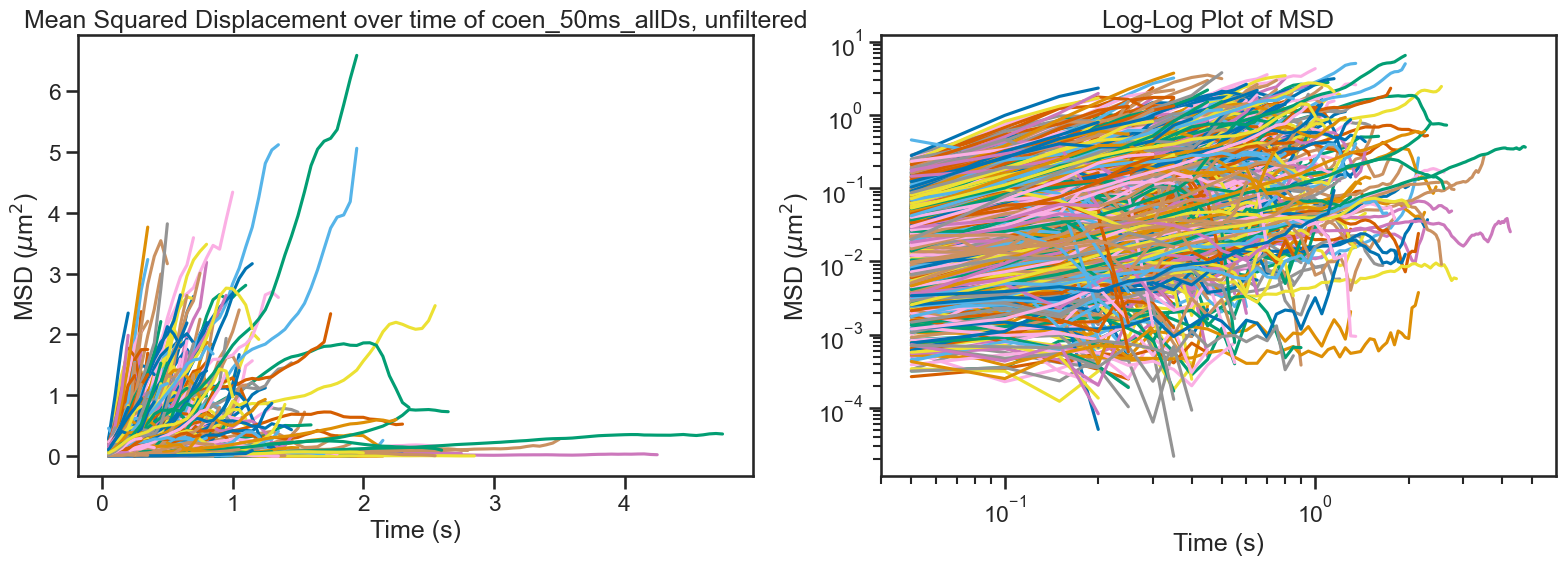

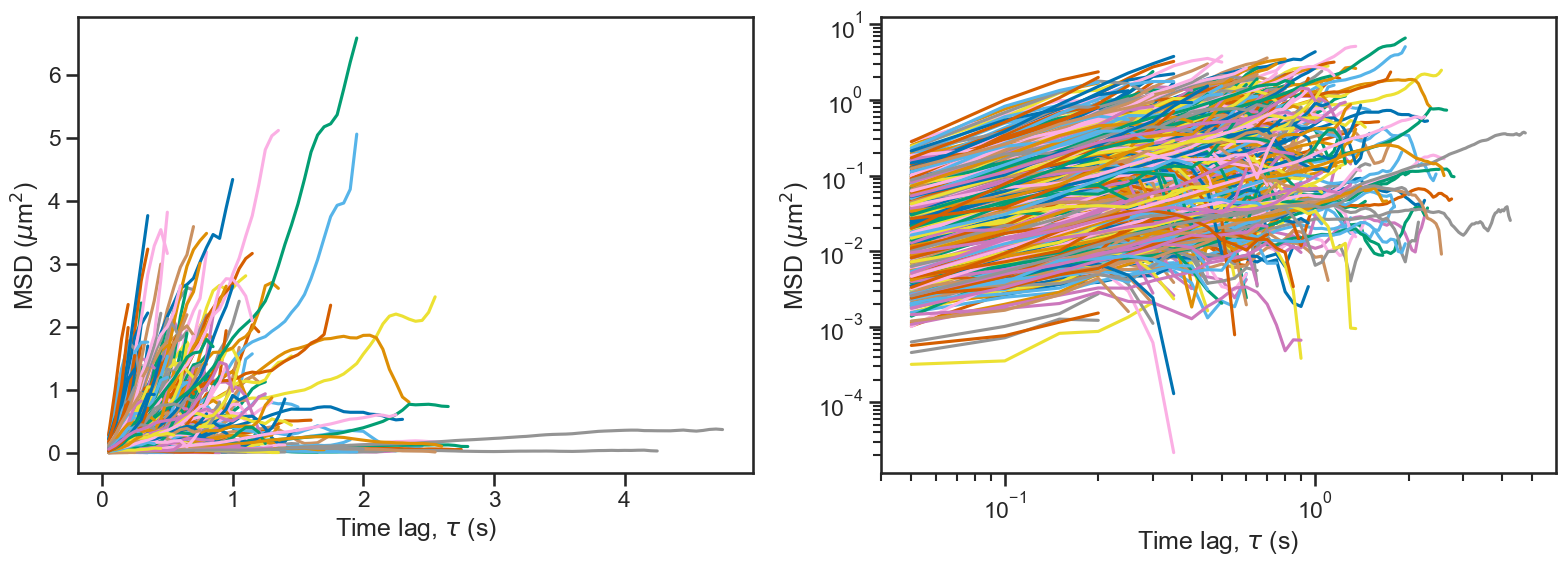

     foci_n lifetime_f lifetime_s msd_per_time_unit D (slope)   R2 y int
0         0        NaN        NaN               NaN       NaN  NaN   NaN
1       NaN        NaN        NaN               NaN       NaN  NaN   NaN
2         0          0          0                 0         0    0     0
3       NaN        NaN        NaN               NaN       NaN  NaN   NaN
4       NaN        NaN        NaN               NaN       NaN  NaN   NaN
...     ...        ...        ...               ...       ...  ...   ...
1454      0          0          0                 0         0    0     0
1455      0          0          0                 0         0    0     0
1456    NaN        NaN        NaN               NaN       NaN  NaN   NaN
1457    NaN        NaN        NaN               NaN       NaN  NaN   NaN
1458    NaN        NaN        NaN               NaN       NaN  NaN   NaN

[1459 rows x 7 columns]
Median after filtering for MSD curve fit above R$^2$  0.9 :  0.21404450915615444


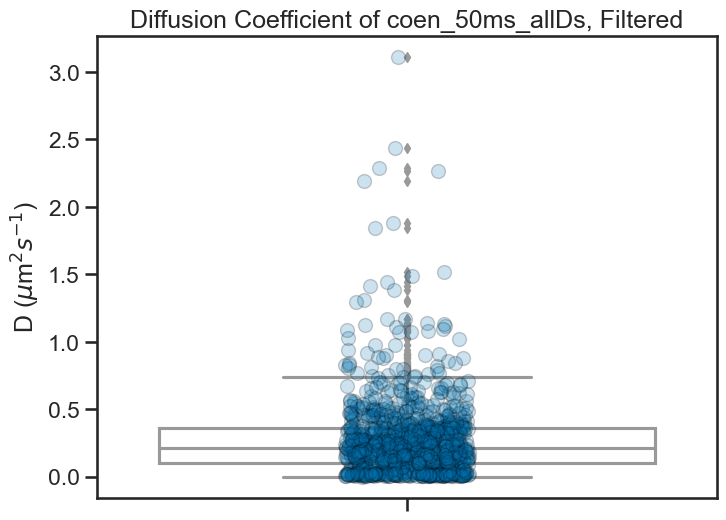

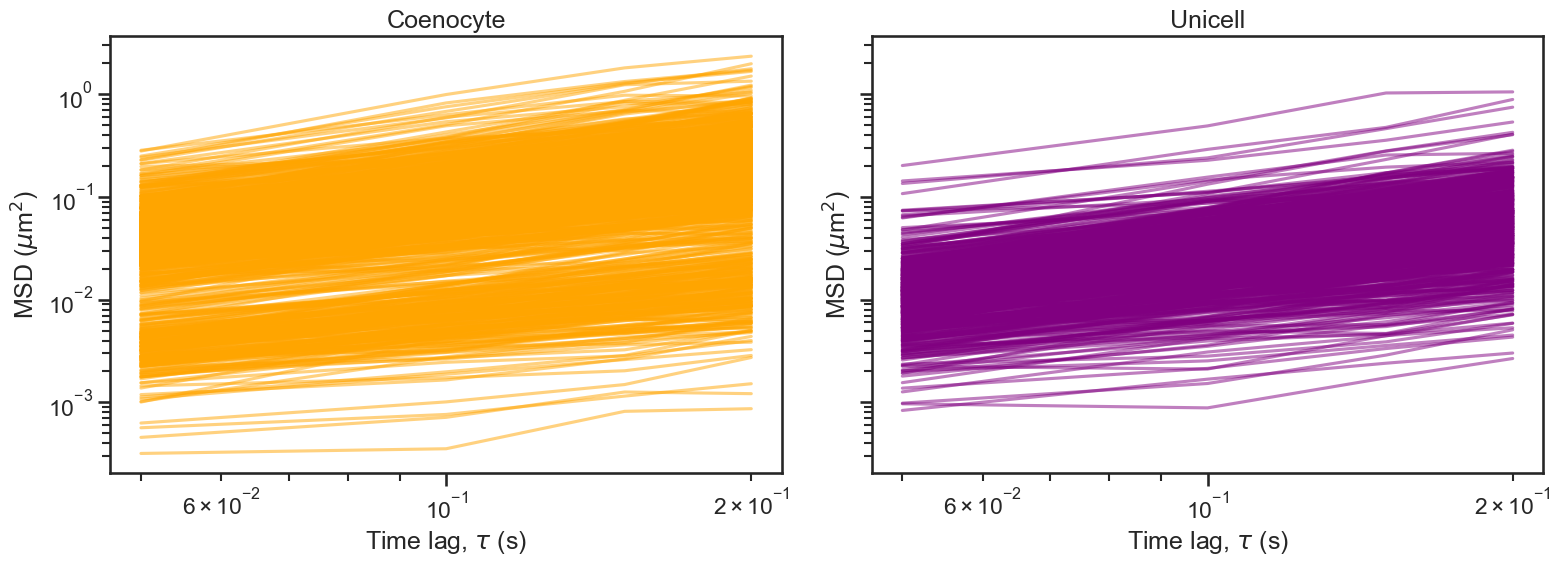

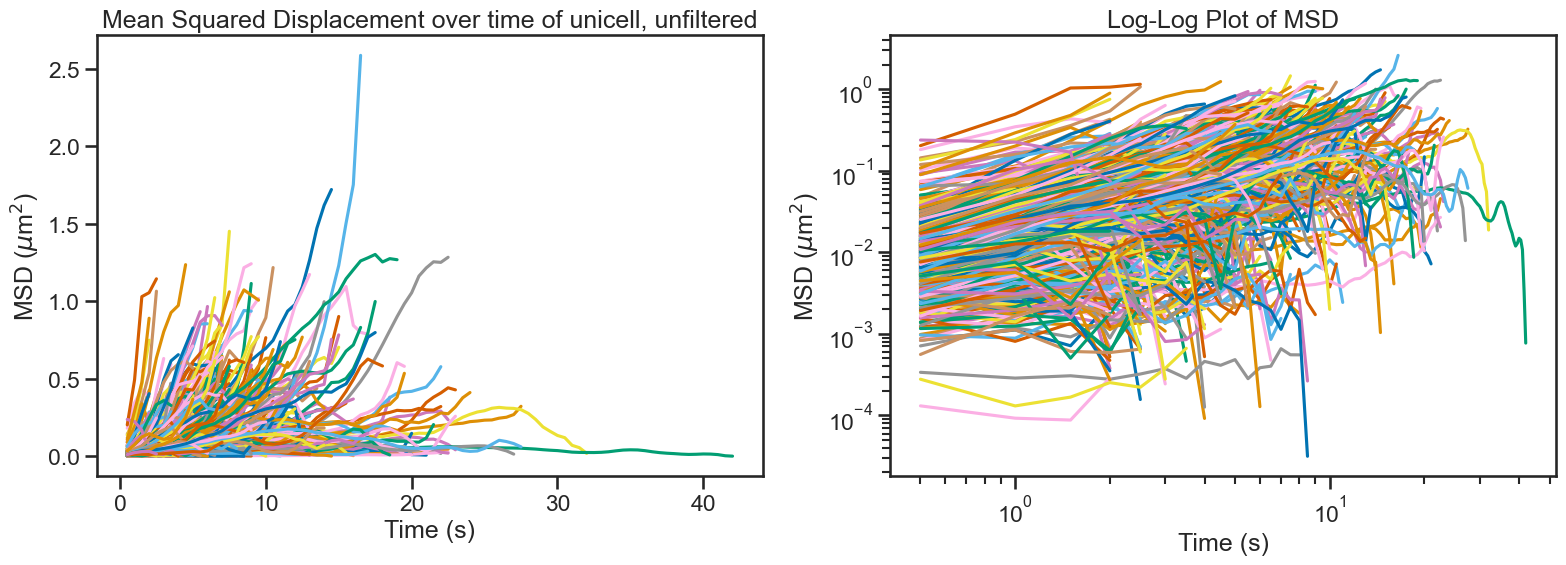

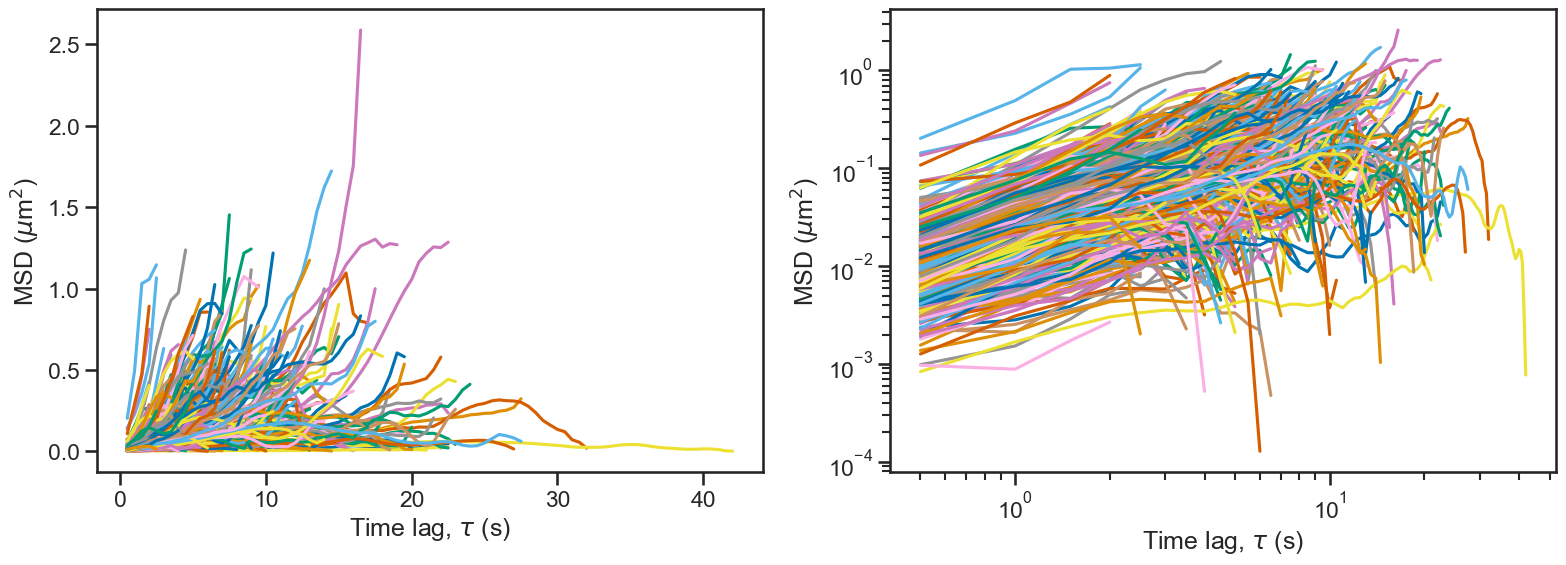

     foci_n lifetime_f lifetime_s msd_per_time_unit D (slope)   R2 y int
0         0        NaN        NaN               NaN       NaN  NaN   NaN
1       NaN        NaN        NaN               NaN       NaN  NaN   NaN
2       NaN        NaN        NaN               NaN       NaN  NaN   NaN
3       NaN        NaN        NaN               NaN       NaN  NaN   NaN
4       NaN        NaN        NaN               NaN       NaN  NaN   NaN
...     ...        ...        ...               ...       ...  ...   ...
1040    NaN        NaN        NaN               NaN       NaN  NaN   NaN
1041    NaN        NaN        NaN               NaN       NaN  NaN   NaN
1042      0          0          0                 0         0    0     0
1043      0          0          0                 0         0    0     0
1044    NaN        NaN        NaN               NaN       NaN  NaN   NaN

[1045 rows x 7 columns]
Median after filtering for MSD curve fit above R$^2$  0.9 :  0.006811738107351837


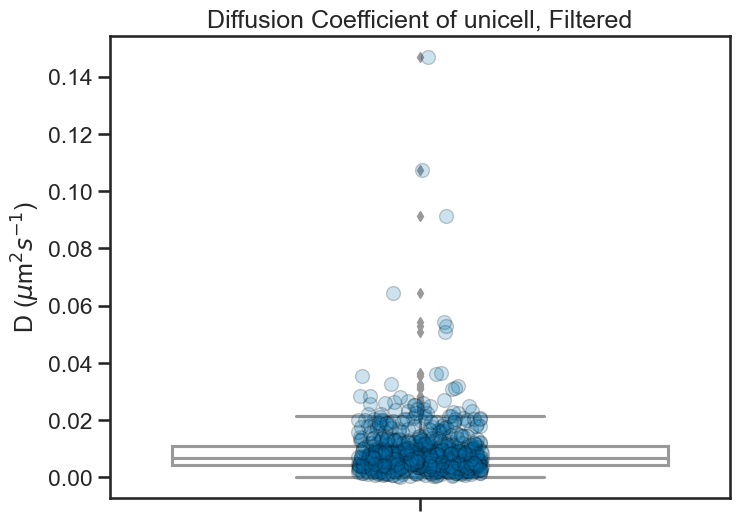

AttributeError: 'NoneType' object has no attribute 'empty'

In [15]:
########################################################################################################################
# Processing Coenocytes grown for 3,6 hours SpoIIIJ and Unicell SpoIIIJ, data collected by O. Leland 8/14/24 and 8/23/24
########################################################################################################################

######################################################################################
# Settings used: 50 ms (coen) 100 pM JFX549 Dye, 500 ms 150 pM JFX549 dye (unicell) #
#####################################################################################

#Run Focitracker, then Graphs. First 5 frame min lifetime and R2 0 or greater (no R2 filter).
#After plotting the freqeuncy distributions in the code block below, I decided on 5 frame min lifetime and R2 0.9 or greater 

#Get the data for each condition (min lifetime is already 5 frames). Convert to CellProfiler format, Run FociTracker on each
import os
coen_50ms = []
unicell = []
os.chdir("C:\\Users\\katie\\Documents\\Folders of Data Analysis\\9324 SpoIIIJ All TrackMate\\")
for dirpath, dirname, filenames in os.walk("."):
    print(f'Found directory: {dirpath}')
    if "R2" in dirpath: #this contains csvs from when I ran it previously. otherwise, it wants to use those csvs.
        pass
    else:
        for file_name in filenames:
            if file_name.endswith(".csv"):
                full_path = os.path.join(dirpath, file_name)
                file = file_name.split('.')[0]
                sample_id = "_".join(file.split('_')[0:2])
                trackMate = TrackMateConverter(full_path)
                trackMate = trackMate.split('.')[0]
                if sample_id=="Coeno_50ms":
                    print("Analyzing: ", trackMate)
                    result = focitracker(trackMate,sample_id, 5, 0.05)
                    coen_50ms.append(result)
                if sample_id=="Unicell_500ms":
                    print("Analyzing: ", trackMate)
                    result = focitracker(trackMate,sample_id, 5, 0.5)
                    unicell.append(result)
                    
#Read in the data from focitracter (all samples of the same condition were put into one folder)

coen_50ms_dataframe = pd.concat(coen_50ms, ignore_index=True)
unicell_dataframe = pd.concat(unicell, ignore_index=True)

graphs(coen_50ms_dataframe, "coen_50ms_allDs", 5, 0.05, 0.9, unicell_dataframe)
graphs(unicell_dataframe, "unicell", 5, 0.5, 0.9)



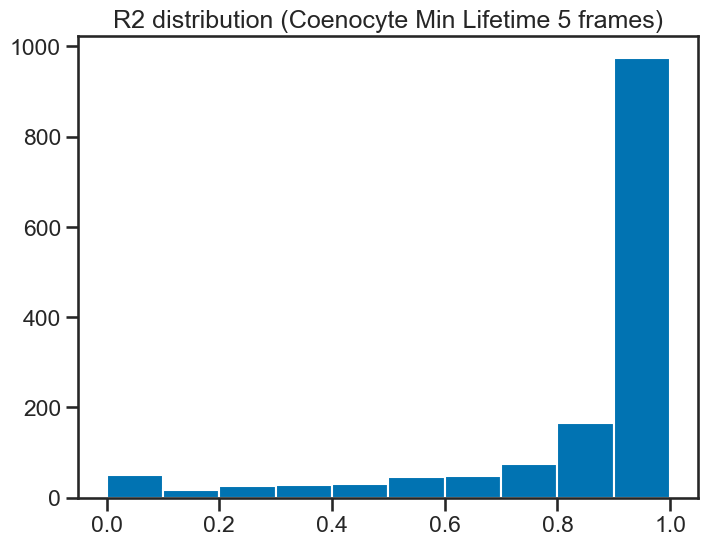

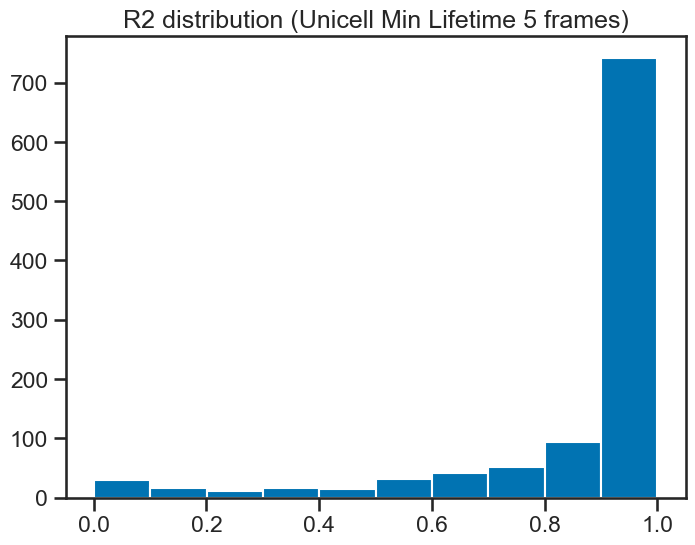

In [127]:
### Extra Graphs: 
#Graph the frequency distribution of frame lifetimes
#Also graph the R2 frequency distribution

#Lifetime distribution
plt.figure(figsize=(8, 6))
plt.title("Lifetime distribution (Coenocyte Min Lifetime 5 frames)") #Change title
d_coen = pd.read_csv("Bestfitcoen_50ms_allDs.csv") ## Change the name of your csv here
d_coen = d_coen.reset_index(drop=True)
plt.hist(d_coen['lifetime_f'].to_list(), bins=np.arange(d_coen['lifetime_f'].min(), d_coen['lifetime_f'].max()+1, 1))
plt.savefig("Lifetimes_coen_50ms_nofilter.png") #Change figure name
plt.show()

#R2 distribution
plt.figure(figsize=(8, 6))
plt.title("R2 distribution (Coenocyte Min Lifetime 5 frames)") #Change title
d_coen = pd.read_csv("Bestfitcoen_50ms_allDs.csv") ## Change the name of your csv here
d_coen = d_coen.reset_index(drop=True)
plt.hist(d_coen['R2'].to_list(), bins=np.arange(d_coen['R2'].min(), d_coen['R2'].max()+0.1, 0.1))
plt.savefig("R2Frequency_coen_50ms_nofilter.png") #Change figure name
plt.show()
